# Dina's table seating arrangements

## Problem

Caroline takes her associates and their families out to a dinner at Dina’s restaurant to celebrate the successes brought to her material planning by Mathematical Optimization.


Caroline puts some additional requirements: to increase social interaction, the different families should sit at tables so that no more than $k$ members of the same family are seated at the same table.

Dina has the following data, plus the desired threshold of at most $k$ family members per table:

 * Family $f$ has $m(f)$ members. 
 * At the restaurant, there are multiple tables, where table $t$ has capacity $c(t)$.

Model this problem in order to find a seating arrangement that satisfies Caroline's requirement.

# Resolution

In [1]:
# Install Pyomo and solvers for Google Colab
import sys
if "google.colab" in sys.modules:
    !wget -N -q https://raw.githubusercontent.com/jckantor/MO-book/main/tools/install_on_colab.py 
    %run install_on_colab.py

In [2]:
import pyomo.environ as pyo
from IPython.display import display
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd


In [3]:
solver = pyo.SolverFactory('cbc')

In [4]:
# %%writefile tableseat_1.py
def TableSeat( members, capacity, k, domain=pyo.NonNegativeReals ):
    m   = pyo.ConcreteModel("Dina's seat plan")
    m.F = pyo.Set( initialize=range( len(members) ) )
    m.T = pyo.Set( initialize=range( len(capacity) ) )
    m.M = pyo.Param( m.F, initialize=members )
    m.C = pyo.Param( m.T, initialize=capacity )
    m.x = pyo.Var( m.F, m.T, bounds=(0,k), domain=domain )
    
    @m.Objective( sense=pyo.maximize )
    def goal(m):
        return 0

    @m.Constraint( m.T )    
    def capacity( m, t ):
        return pyo.quicksum( m.x[f,t] for f in m.F  ) <= m.C[t]
    
    @m.Constraint( m.F )
    def seat( m, f ):
        return pyo.quicksum( m.x[f,t] for t in m.T ) == m.M[f]
        
    return m

In [5]:
def TableSeatAsMaxFlow( members, capacity, k, domain=pyo.NonNegativeReals ):
    m   = pyo.ConcreteModel("Dina's seat plan")
    m.F = pyo.Set( initialize=range( len(members) ) )
    m.T = pyo.Set( initialize=range( len(capacity) ) )
    m.M = pyo.Param( m.F, initialize=members )
    m.C = pyo.Param( m.T, initialize=capacity )
    m.x = pyo.Var( m.F, m.T, bounds=(0,k), domain=domain )
    
    @m.Objective( sense=pyo.maximize )
    def goal(m):
        return pyo.quicksum( m.x[f,t] for t in m.T for f in m.F )

    @m.Constraint( m.T )    
    def capacity( m, t ):
        return pyo.quicksum( m.x[f,t] for f in m.F  ) <= m.C[t]
    
    @m.Constraint( m.F )
    def seat( m, f ):
        return pyo.quicksum( m.x[f,t] for t in m.T ) <= m.M[f]
        
    return m

In [6]:
def Reset( model ) -> None:
    for v in model.component_data_objects(ctype=pyo.Var, descend_into=True):
        v.set_value(None)
        
def GetSolution( model ):
    import pandas as pd
    sol = pd.DataFrame()
    for idx,x in model.x.items():
        sol.loc[idx]=x()
    return sol
    
def Report( model, results, type=float ):
    print(results.solver.status, results.solver.termination_condition )
    if results.solver.termination_condition == 'optimal':
        sol = GetSolution(model).astype(type)
        display( sol )
        print('objective       ', pyo.value( seatplan.goal ) )
        print('places at table ', list(sol.sum(axis=0)))
        print('members seated  ', list(sol.sum(axis=1)))

In [7]:
seatplan = TableSeat( [6,8,2,9,13,1], [8,8,10,4,9], 3 )

%time results = solver.solve(seatplan)

Report( seatplan,results )

    solver failure.
CPU times: user 10.4 ms, sys: 18 ms, total: 28.5 ms
Wall time: 281 ms
ok optimal


,0,1,2,3,4
0,2.0,3.0,1.0,0.0,1.000089e-12
1,2.0,0.0,3.0,0.0,3.000000e+00
2,2.0,0.0,0.0,0.0,0.000000e+00
3,0.0,2.0,3.0,1.0,3.000000e+00
4,1.0,3.0,3.0,3.0,3.000000e+00
5,1.0,0.0,0.0,0.0,0.000000e+00


objective        0.0
places at table  [8.0, 8.0, 10.0, 4.0, 9.000000000001]
members seated   [6.000000000001, 8.0, 2.0, 9.0, 13.0, 1.0]


In [8]:
import pyperclip 
pyperclip.copy( GetSolution(seatplan).astype(int).style.to_latex() )

ModuleNotFoundError: No module named 'pyperclip'

In [ ]:
def TableSeatMinimizeMaxGroupAtTable( members, capacity, nature=pyo.NonNegativeReals ):
    m   = pyo.ConcreteModel("Dina's seat plan")
    m.F = pyo.Set( initialize=range( len(members) ) )
    m.T = pyo.Set( initialize=range( len(capacity) ) )
    m.M = pyo.Param( m.F, initialize=members )
    m.C = pyo.Param( m.T, initialize=capacity )
    m.x = pyo.Var( m.F, m.T, domain=nature )
    m.k = pyo.Var( domain=nature )
    
    @m.Objective( sense=pyo.minimize )
    def goal(m):
        return m.k
    
    @m.Constraint( m.T )    
    def capacity( m, t ):
        return pyo.quicksum( m.x[f,t] for f in m.F  ) <= m.C[t]
    
    @m.Constraint( m.F )
    def seat( m, f ):
        return pyo.quicksum( m.x[f,t] for t in m.T ) == m.M[f]

    @m.Constraint( m.F, m.T )
    def bound( m, f, t ):
        return m.x[f,t] <= m.k

    return m

In [ ]:
seatplan = TableSeatMinimizeMaxGroupAtTable( [6,8,2,9,13,1], [8,8,10,4,9], nature=pyo.NonNegativeReals )

%time results = solver.solve(seatplan)

Report( seatplan, results )

In [ ]:
pyperclip.copy( GetSolution(seatplan).astype(float).style.format(precision=2).to_latex() )

In [ ]:
def TableSeatMinimizeNumberOfTables( members, capacity, k, nature=pyo.NonNegativeReals ):
    m   = pyo.ConcreteModel("Dina's seat plan")
    m.F = pyo.Set( initialize=range( len(members) ) )
    m.T = pyo.Set( initialize=range( len(capacity) ) )
    m.M = pyo.Param( m.F, initialize=members )
    m.C = pyo.Param( m.T, initialize=capacity )
    m.x = pyo.Var( m.F, m.T, bounds=(0,k), domain=nature )
    m.y = pyo.Var( m.T, within=pyo.Binary )
    
    @m.Objective( sense=pyo.minimize )
    def goal(m):
        return pyo.quicksum(m.y[t] for t in m.T)
    
    @m.Constraint( m.T )    
    def capacity( m, t ):
        return pyo.quicksum( m.x[f,t] for f in m.F  ) <= m.C[t]*m.y[t]
    
    @m.Constraint( m.F )
    def seat( m, f ):
        return pyo.quicksum( m.x[f,t] for t in m.T ) == m.M[f]

    return m

In [ ]:
seatplan = TableSeatMinimizeNumberOfTables( [6,8,2,9,13,1], [8,8,10,4,9], 3, pyo.NonNegativeIntegers )

%time results = solver.solve(seatplan)

Report( seatplan, results, int )

# Note: this is an example of a max flow!

In [9]:

%matplotlib inline

# https://stackoverflow.com/questions/17687213/how-to-obtain-the-same-font-style-size-etc-in-matplotlib-output-as-in-latex
params = {'text.usetex' : True,
          'font.size'   : 10, # the book seems to be in 10pt, change if needed
          'font.family' : 'lmodern',
          }

plt.rcParams.update(params)
default_size_inches = (3.54,3.54) 
plt.rcParams['figure.figsize'] = default_size_inches

In [10]:
def ModelAsNetwork( members, capacity, k ):
    families = [f'f{i}' for i in range(len(members))]
    tables = [f't{j}' for j in range(len(capacity))]
    G = nx.DiGraph()
    G.add_node('door',layer=0)
    for f in families:
        G.add_node(f,layer=1)
    for t in tables:
        G.add_node(t,layer=2)
    G.add_node('seat',layer=3)
    for f,n in zip(families,members):
        G.add_edge('door', f, capacity=n)
    for f in families:
        for t in tables:
            G.add_edge(f,t, capacity=k)
    for t,n in zip(tables,capacity):
        G.add_edge(t, 'seat', capacity=n)
    return G

In [11]:
G = ModelAsNetwork( [6,8,2,9,13,1], [8,8,10,4,9], 3 )

In [12]:
pos = nx.multipartite_layout(G, subset_key='layer')

In [13]:
labels = { (e[0],e[1]) : e[2] for e in G.edges(data='capacity') }

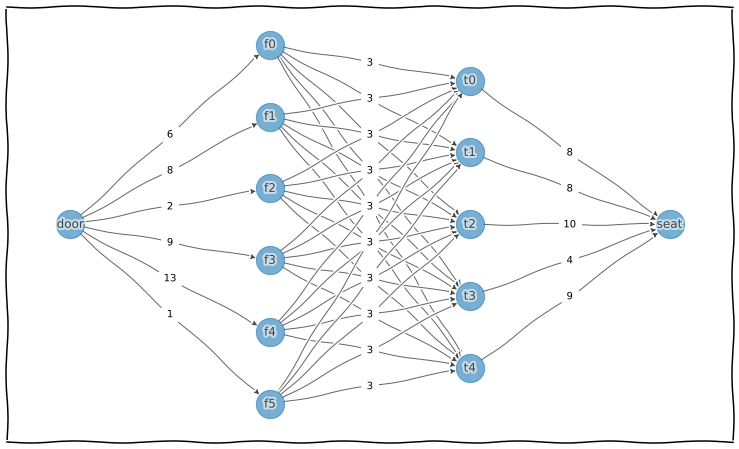

In [14]:
plt.rcParams['text.usetex'] =False
with plt.xkcd():
    fig = plt.figure(figsize=(13,8))
    ax = fig.add_subplot(111)
    nx.draw_networkx(G,pos=pos,ax=ax,node_size=800,with_labels=True,alpha=.6)
    _=nx.draw_networkx_edge_labels(G,pos=pos,ax=ax,edge_labels=labels,font_color='black',rotate=False,alpha=1)
    fig.savefig( 'net_flow.pdf', bbox_inches='tight', pad_inches=0 )


In [15]:
%time flow_value, flow_dict = nx.maximum_flow(G, 'door', 'seat')

CPU times: user 970 µs, sys: 33 µs, total: 1 ms
Wall time: 1.01 ms


In [16]:
members, capacity = [6,8,2,9,13,1], [8,8,10,4,9]
families = [f'f{i}' for i in range(len(members))]
tables = [f't{j}' for j in range(len(capacity))]
pd.DataFrame(flow_dict).loc[tables,families]

,f0,f1,f2,f3,f4,f5
t0,1.0,0.0,0.0,3.0,3.0,1.0
t1,0.0,2.0,0.0,3.0,3.0,0.0
t2,1.0,3.0,0.0,3.0,3.0,0.0
t3,1.0,0.0,0.0,0.0,3.0,0.0
t4,3.0,3.0,2.0,0.0,1.0,0.0


In [17]:
flow_edges = [(a,b) for a,B in flow_dict.items() for b,v in B.items() if v>0 and a != 'door' and b != 'seat']
flow_nodes = [n for n in G.nodes if n.startswith('f') or n.startswith('t')]

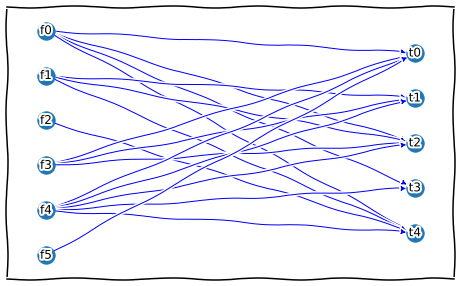

In [18]:
with plt.xkcd():
    fig = plt.figure(figsize=(8,5))
    nx.draw_networkx(G,ax=fig.add_subplot(111),pos=pos,node_size=300,edge_color='blue',edgelist=flow_edges,nodelist=flow_nodes)

In [19]:
fig.savefig( 'flow.pdf', bbox_inches='tight', pad_inches=0 )

In [20]:
cbc    = pyo.SolverFactory('cbc')
gurobi = pyo.SolverFactory('gurobi_direct')

In [21]:
from pathlib import Path
if Path('dina_times.xlsx').is_file():
    df = pd.read_excel('dina_times.xlsx').set_index('Unnamed: 0')
else:
    from tqdm.notebook import tqdm
    from time import perf_counter as pc
    import numpy as np
    np.random.seed(2022)
    k = 3
    nmax = 500
    mmax = 2*nmax
    sizes = list(zip(range(10,nmax,10),range(20,mmax,20)))
    df = pd.DataFrame(index=['cbc','gurobi','nx'],columns=sizes)
    for n,m in tqdm(sizes):
        members, capacity = np.random.randint(1,10,n), np.random.randint(3,8,m)
        model = TableSeatAsMaxFlow(members,capacity,k)
        t=pc() 
        cbc.solve(model)
        df.loc['cbc'][(n,m)] = pc()-t
        Reset(model)
        t=pc() 
        gurobi.solve(model)
        df.loc['gurobi'][(n,m)] = pc()-t
        G = ModelAsNetwork(members,capacity,k)
        t = pc()
        nx.maximum_flow(G, 'door', 'seat')
        df.loc['nx'][(n,m)] = pc()-t
        
    df.to_excel('dina_times.xlsx')

In [22]:
aux = df.T

In [23]:
df

,"(10, 20)","(20, 40)","(30, 60)","(40, 80)","(50, 100)","(60, 120)","(70, 140)","(80, 160)","(90, 180)","(100, 200)",...,"(400, 800)","(410, 820)","(420, 840)","(430, 860)","(440, 880)","(450, 900)","(460, 920)","(470, 940)","(480, 960)","(490, 980)"
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
cbc,0.094727,0.084132,0.120244,0.172141,0.223353,0.320543,0.374295,0.452540,0.667402,0.710549,...,13.350693,14.753052,18.444643,17.659208,16.619090,17.909117,22.313041,22.550129,21.942068,21.800375
gurobi,0.043392,0.034781,0.134984,0.112127,0.304981,0.329835,0.420639,0.484730,0.665472,0.897768,...,14.986658,17.618462,21.198270,20.555059,18.400325,22.321826,24.893338,25.507576,21.337107,25.497099
nx,0.002665,0.007776,0.020841,0.031215,0.051511,0.067398,0.088514,0.114161,0.173439,0.194617,...,4.319810,5.824088,5.281828,3.809972,4.966340,6.697136,6.940013,7.345105,6.026856,6.781781


In [24]:
aux

Unnamed: 0,cbc,gurobi,nx
"(10, 20)",0.094727,0.043392,0.002665
"(20, 40)",0.084132,0.034781,0.007776
"(30, 60)",0.120244,0.134984,0.020841
"(40, 80)",0.172141,0.112127,0.031215
"(50, 100)",0.223353,0.304981,0.051511
"(60, 120)",0.320543,0.329835,0.067398
"(70, 140)",0.374295,0.420639,0.088514
"(80, 160)",0.452540,0.484730,0.114161
"(90, 180)",0.667402,0.665472,0.173439
"(100, 200)",0.710549,0.897768,0.194617


In [25]:
import numpy as np
plt.rcParams['text.usetex'] =True
fig = plt.figure(figsize=(13,5))
ax=fig.add_subplot(111)
aux.plot(ax=ax)
plt.xticks(np.arange(len(df.columns)),df.columns,rotation = 45)
plt.show()

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 936x360 with 1 Axes>

In [26]:
fig.savefig( 'dina_times.pdf', bbox_inches='tight', pad_inches=0 )

RuntimeError: Failed to process string with tex because latex could not be found